# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

In [30]:
#Librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score as precision
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

### Lectura y análisis de datos
Leemos los datos directamente desde un repositorio de github.

In [24]:
datos = pd.read_csv("./datos/sms-spam.csv",
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')
datos.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


 vemos que los datos están compuestos por dos columnas, texto y tipo, el tipo indica si es spam o no.
 El conjunto de datos está compuesto por muchos textos que no son spam, en comparación con los que son.
 ###### Distribución de los datos

In [6]:
df.type.value_counts()

ham     4827
spam     747
Name: type, dtype: int64

###### Stemmer
Ahora se realiza la parte de stemming a los datos, el cúal consiste en reducir cada una de las palabras a su raíz, esto con el fin de limpiar el texto y eliminar palabras innecesarias para resolver el problema, como conectores.
Se crea una nueva columna en el dataframe con el stemmed

In [7]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(10)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...
6,ham,Even my brother is not like to speak with me. ...,even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...,As per your request 'mell mell (oru minnaminun...
8,spam,WINNER!! As a valued network customer you have...,winner!! As a valu network custom you have bee...
9,spam,Had your mobile 11 months or more? U R entitle...,had your mobil 11 month or more? U R entitl to...


###### CountVectorizer
Se encarga de convertir el texto a una matriz de tokens, es decir, convierte el texto en una matriz de números ya que los algoritmos de entrenamiento solo reciben datos como números.

In [8]:
##
## Matriz de términos del documento en Python
##
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja freq
)


##
## Aplica la función al texto
##
dtm = count_vect.fit_transform(df.stemmed)

##
## Las filas contienen los mensajes
## y las clomunas los términos
##
dtm.shape

(5574, 1540)

In [9]:
##
## Palabras aprendidas de los mensajes de texto
##
vocabulary = count_vect.get_feature_names()
len(vocabulary)

1540

In [10]:
##Este es el resultado al convertir el textoa tokens.
## Primeras palabras del vocabulario
##
vocabulary[0:10]

['00',
 '000',
 '02',
 '03',
 '04',
 '06',
 '0800',
 '08000839402',
 '08000930705',
 '0870']

Esta función se encarga de hacer el proceso inverso a CountVectorizer, convertir esos tokens o "números" en texto nuevamente.

In [11]:
##
## Recupera los mensajes de la dtm
##
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])):
    print('Org: ', df.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx

Org:  Even my brother is not like to speak with me. They treat me like aids patent.
Mod:  brother like speak treat

Or

Para más facilidad se crea una variable tipo, que contiene los tipos de texto (ham, spam) pero en ceros y unos, se hace con el fin de facilitar y poder trabajar con estos datos en los algoritmos de entrenamiento y predicción.

In [12]:
tipo = df.type.map(dict(ham=1, spam=0))
type(tipo)

pandas.core.series.Series

### Regresión Logística
Esta regresión es muy útil para predecir el resultado de una variable categórica en función de las variables independientes, como en este caso, la variable tipo es categórica (ham,spam).

In [25]:
#Hacemos la partición de los datos utilizando train_test_split a un 80% entrenamiento, 20% pronóstico.
X_train, X_test, y_train, y_test = train_test_split(dtm.toarray(), tipo, random_state=42,test_size=0.2)

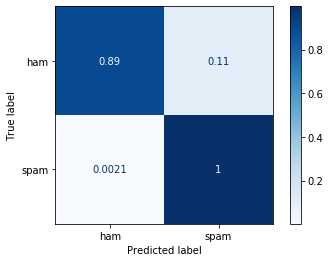

In [26]:
#Realizamos la regresión logística y graficamos su matriz de confusión
logistica = LogisticRegression(random_state=42).fit(X_train, y_train)
pronostico = logistica.predict(X_test)
plot_confusion_matrix(logistica, X_test, y_test,
                           display_labels=['ham', 'spam'],
                           cmap=plt.cm.Blues,
                           normalize='true')


In [15]:
precision(y_test, pronostico)

0.9829596412556054

Los resultados de la regresión logística son muy buenos, arrojando una precisión del 98%, se nota en la matriz de confusión el desempeño que tiene, aunque hay un 11% de datos que predijo mal para ham, pero esto también se debe a la distribución de datos inicial, en el que vimos que hay muchas más muestras de datos tipo ham, que de tipo spam.

### Modelo Red Neuronal
Se utilizará una red neuronal de tipo clasificador (MLPClassifier) en el cual para encontrar sus parámetros óptimos se recurre a la libreria GridSearchCV de sklearn, que lo hace utilizando validación cruzada.

In [16]:
#Red Neuronal
Mlpc = MLPClassifier(max_iter=200)
parametros = {"hidden_layer_sizes": [(2,),(5,),(7,),(9,)],'activation': ['logistic','relu']}
GSC = GridSearchCV(Mlpc, parametros,cv=3,scoring='precision')
GSC.fit(X_train,y_train)
print(GSC.best_params_)

C:\Users\Jhonier\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Jhonier\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Jhonier\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Jhonier\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_it

{'activation': 'logistic', 'hidden_layer_sizes': (9,)}


###### Datos óptimos Red Neuronal
* Función de activación: Logistica
* Número de neuronal: 9

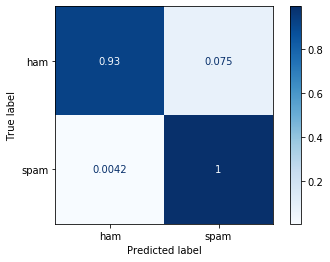

In [29]:
plot_confusion_matrix(GSC, X_test, y_test,
                           display_labels=['ham', 'spam'],
                           cmap=plt.cm.Blues,
                           normalize='true')


In [27]:
print("Score",GSC.score(X_test, y_test))

Score 0.9875259875259875


La red neuronal también dio muy buenos resultados para este problema.Muy similares a los de la regresión logística, pero se puede notar gracias a la matriz de confusión que clasifico casi un 4% mejor los ham.

In [39]:
#Naive
X_train, X_test, y_train, y_test = train_test_split(datos["text"], tipo, random_state=42,test_size=0.2)


count_vector = CountVectorizer()
training_data = count_vector.fit_transform(X_train)
testing_data = count_vector.transform(X_test)

naive = MultinomialNB()
naive.fit(training_data, y_train)
pronostico = naive.predict(testing_data)



<class 'scipy.sparse.csr.csr_matrix'>


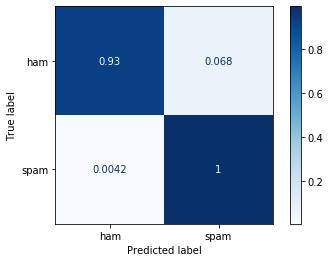

In [40]:
plot_confusion_matrix(naive, testing_data.toarray(), y_test,
                           display_labels=['ham', 'spam'],
                           cmap=plt.cm.Blues,
                           normalize='true')


In [34]:
print("Precision:",precision(y_test, pronostico))

Precision: 0.9865470852017937


Este modelo también dio resultados muy similares a los otros dos utilizados (Regresión logística y Redes neuronales clasificador),de igual manera mejoró un poco en el pronóstico de los ham.
Puede ser un modelo muy interesante de usar, ya que con respecto a las redes neuronales, no tiene un tiempo de computo elevado.